In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.naive_bayes import MultinomialNB
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, balanced_accuracy_score, f1_score, precision_score
from sklearn.decomposition import TruncatedSVD

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.pipeline import make_pipeline

In [2]:
#Load in dataframe to model
df = pd.read_csv('../data/cleaning_data_phase2.csv.zip')
df.head()

,_michd,_sex,genhlth,physhlth,menthlth,addepev3,checkup1,_totinda,_rfhype6,cholmed3,...,_metstat,_imprace,_age80,_educag,ftjuda2_,frutda2_,grenda1_,frnchda_,potada1_,vegeda2_
0,No,Female,Poor,20.0,10.0,No,Within past 2 years (1 year but < 2 years ago),No physical activity or exercise in last 30 days,No,Yes,...,yes,white,70.0,highschool,5.397605e-79,100.0,5.700000e+01,4.300000e+01,14.0,100.0
1,Yes,Female,Good,0.0,0.0,No,Within past year (anytime < 12 months ago),Had physical activity or exercise,Yes,Yes,...,yes,black,67.0,graduated college,5.397605e-79,100.0,1.400000e+01,5.397605e-79,14.0,100.0
2,Yes,Female,Very good,0.0,0.0,No,Within past year (anytime < 12 months ago),No physical activity or exercise in last 30 days,Yes,No,...,yes,black,72.0,highschool,5.397605e-79,100.0,5.397605e-79,1.400000e+01,14.0,43.0
3,No,Female,Very good,0.0,10.0,No,Within past year (anytime < 12 months ago),Had physical activity or exercise,Yes,No,...,yes,white,62.0,highschool,7.100000e+01,43.0,1.000000e+01,5.700000e+01,27.0,71.0
4,Yes,Male,Poor,30.0,0.0,No,Within past year (anytime < 12 months ago),Had physical activity or exercise,No,Yes,...,no,other race,76.0,no highschool,5.397605e-79,100.0,1.000000e+02,2.900000e+01,29.0,100.0


# Missing data:

There are missing values in the dataset, to deal with this we will try different methods of imputation. When imputing, we will treat numerical and categorical features differently.

In [3]:
df.isnull().sum()

_michd          0
_sex            0
genhlth         0
physhlth     8491
menthlth     7084
addepev3        0
checkup1        0
_totinda        0
_rfhype6        0
cholmed3        0
_rfchol3        0
cvdstrk3        0
_asthms1        0
chcscncr        0
chcocncr        0
chccopd3        0
chckdny2        0
diabete4        0
_drdxar3        0
marital         0
children     3684
_incomg1        0
employ1         0
htm4         9849
wtkg3       25486
_bmi5       30786
decide          0
diffwalk        0
diffdres        0
_state          0
_smoker3        0
usenow3         0
ecignow1        0
_drnkwk1    15125
_metstat        0
_imprace        0
_age80          0
_educag         0
ftjuda2_    24072
frutda2_    23649
grenda1_    23943
frnchda_    24471
potada1_    28095
vegeda2_    28150
dtype: int64

In [4]:
#For imputation later
#List of categorical features
categorical_features = [df.columns[i] for i in range(len(df.columns)) if df.dtypes[i] == 'object']
categorical_features.remove('_michd') #No need to have the target variable in there

#List of numerical features
numerical_features = [df.columns[i] for i in range(len(df.columns)) if df.dtypes[i] == 'float64']

# Splitting the data into a train and test group

In [5]:
#Features to be used in model
X = df.drop(columns = '_michd')

#Target variable
y = df['_michd'].map({'Yes':1, 'No':0})

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

# Metric Function

In [7]:
#Function to display metrics of interest
def my_metrics(estimator, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):
    
    train_preds = estimator.predict(X_train)
    preds = estimator.predict(X_test)
    
    train_acc = accuracy_score(y_train, train_preds)
    train_recall = recall_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)
    balanced = balanced_accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    precision = precision_score(y_test, preds)
    
    print(f'Train Accuracy: {train_acc}')
    print(f'Test Recall: {train_recall}')
    print(f'Test Accuracy: {test_acc}')
    print(f'Balanced Accuracy: {balanced}')
    print(f'Recall: {recall}')
    print()
    print(f'Test Confusion Matrix:')
    
    ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test)
    
    return {
        'balanced_accuracy': balanced,
        'recall': recall,
        'precision': precision,
        'f1_score': f1
    }

# First model:

**Strategy:**
- Impute numerical values with median
- All else is default to multnomial Naive Bayes

In [8]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('median_imputer', SimpleImputer(strategy = 'median'))
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#Estimator pipeline with our preprocessing in there
multi_nb_classifier = Pipeline([
    ('pre', preprocess),
    ('mnb', MultinomialNB())
])

multi_nb_classifier.fit(X_train, y_train);

In [9]:
#List that will keep track of metrics
history = []

Train Accuracy: 0.331156737422117
Test Recall: 0.8274215018401065
Test Accuracy: 0.3310109236885784
Balanced Accuracy: 0.5575509776483296
Recall: 0.8286351891003054

Test Confusion Matrix:


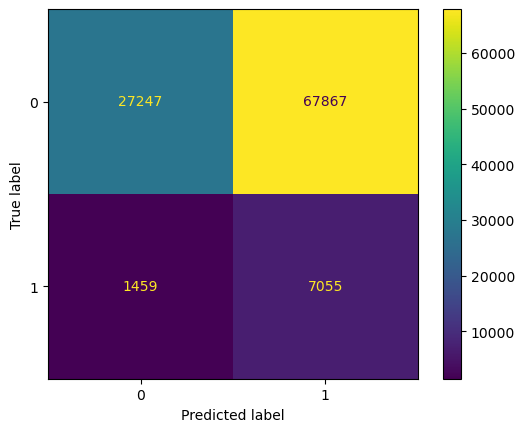

In [10]:
#Metrics
history.append(my_metrics(multi_nb_classifier))

Although this has a very low accuracy score, recall is quite high. Out of every 10 people with hear disease, this model is able to pick up on 80% of them. The issue is that it also predict many many healthy people to be sick as well.

# Second model:

**Strategy:**
- Build off of first model
- Grid search over different imputing strategies and MultiNB hyper params

In [11]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer())
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#Estimator pipeline with our preprocessing in there
multi_nb_classifier = Pipeline([
    ('pre', preprocess),
    ('mnb', MultinomialNB())
])

#Parameter for the grid search
grid_params = {
    'pre__numerical__imputer__strategy': ['mean', 'median', 'most_frequent'], #Different imputation strategies
    'mnb__alpha': [.001,.01,.1,1,10] #Different alpha values
}

#Grid Search with maximizing balanced accuracy
grid_mnb_class = GridSearchCV(multi_nb_classifier, grid_params, scoring = 'recall') #Maximize for recall

#Fit model to training data
grid_mnb_class.fit(X_train, y_train);

/Users/lucas_ogilvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lucas_ogilvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/lucas_ogilvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/lucas_ogilvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/lucas_ogilvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/lucas_ogilvie/opt/anaconda3/lib/python3.9/site-

Train Accuracy: 0.35225792339883494
Test Recall: 0.8098817633701355
Test Accuracy: 0.3531960474003165
Balanced Accuracy: 0.5622041515514025
Recall: 0.8123091378905333

Test Confusion Matrix:


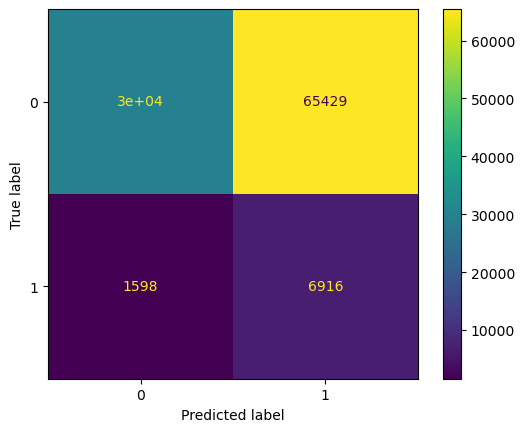

In [12]:
#Metrics
history.append(my_metrics(grid_mnb_class))

In [13]:
grid_mnb_class.best_params_

{'mnb__alpha': 0.001, 'pre__numerical__imputer__strategy': 'mean'}

In [14]:
pd.DataFrame(history, index = ['impute with median', 'gridsearch over params'])

,balanced_accuracy,recall,precision,f1_score
impute with median,0.557551,0.828635,0.094165,0.169112
gridsearch over params,0.562204,0.812309,0.095597,0.171063


The secon model had slightly higher accuracy but slightly worse recall. The best imputer strategy was mean imputation.

# Third model

**Strategy:**
- Build off of second model
- Use best hyperparams found from the second model so we don't need to grid search and save time
- Impute for categorical variables: 
    - Replace values like 'missing', 'not sure', 'refused' with one constant value of 'missing'

In [15]:
#Replacing all values of the 'don't know', 'refused' and 'missing' sort with None values to represent them as missing for our imputer
X_train_cleaned = X_train.replace(["Don't know/Not sure", 'Refused', 'Not asked or Missing', 'Don’t know/Refused/Missing', 
 'Don’t know/Not Sure/Refused/Missing', 'Don’t know/Not Sure Or Refused/Missing',
 'not sure', 'refused', 'unknown', 'missing', 'Don’t know/Not Sure', 'not_sure'], 'missing')

X_test_cleaned = X_test.replace(["Don't know/Not sure", 'Refused', 'Not asked or Missing', 'Don’t know/Refused/Missing', 
 'Don’t know/Not Sure/Refused/Missing', 'Don’t know/Not Sure Or Refused/Missing',
 'not sure', 'refused', 'unknown', 'missing', 'Don’t know/Not Sure', 'not_sure'], 'missing')


In [16]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')) #Imputing median for missing values
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#Estimator pipeline with our preprocessing in there
multi_nb_classifier = Pipeline([
    ('pre', preprocess),
    ('mnb', MultinomialNB(alpha = .00000001))
])

#Fit model
multi_nb_classifier.fit(X_train_cleaned, y_train);

Train Accuracy: 0.3296384813579385
Test Recall: 0.8273040482342808
Test Accuracy: 0.3293607905199367
Balanced Accuracy: 0.556652056353883
Recall: 0.8286351891003054

Test Confusion Matrix:


,balanced_accuracy,recall,precision,f1_score
impute with median,0.557551,0.828635,0.094165,0.169112
gridsearch over params,0.562204,0.812309,0.095597,0.171063
impute with median and group missing into one category,0.556652,0.828635,0.093950,0.168766


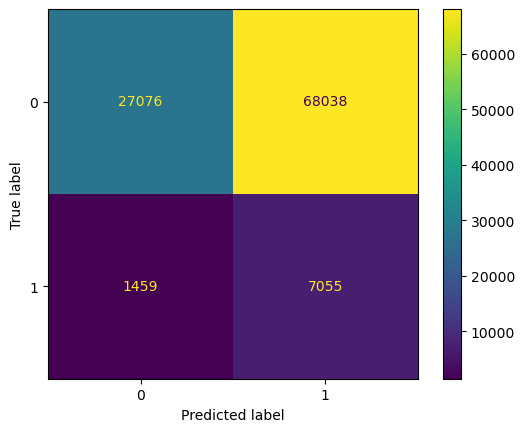

In [17]:
#Metrics
history.append(my_metrics(multi_nb_classifier, X_train_cleaned, X_test_cleaned))

pd.DataFrame(history, index = ['impute with median', 'gridsearch over params', 'impute with median and group missing into one category'])

Better Recall but worse accuaracy. Not much different than past two models.

# Fourth Model:

**Strategy:**
- Let's try and add some Min Max scaler to numerical pipeline

Train Accuracy: 0.8584161887269487
Test Recall: 0.4870801033591731
Test Accuracy: 0.8571235573397151
Balanced Accuracy: 0.6869527594173319
Recall: 0.48332158797275077

Test Confusion Matrix:


,balanced_accuracy,recall,precision,f1_score
impute with median,0.557551,0.828635,0.094165,0.169112
gridsearch over params,0.562204,0.812309,0.095597,0.171063
impute with median and group missing into one category,0.556652,0.828635,0.093950,0.168766
MinMax Scaler,0.686953,0.483322,0.283363,0.357267


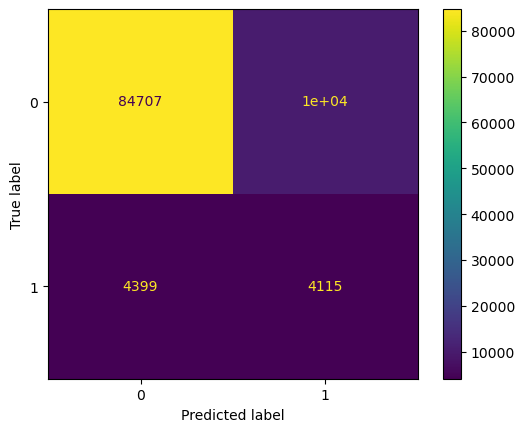

In [18]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')), #Imputing median for missing values
    ('mms', MinMaxScaler())
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#Estimator pipeline with our preprocessing in there
multi_nb_classifier = Pipeline([
    ('pre', preprocess),
    ('mnb', MultinomialNB(alpha = .0001))
])

#Fit model
multi_nb_classifier.fit(X_train_cleaned, y_train);

#Metrics
history.append(my_metrics(multi_nb_classifier, X_train_cleaned, X_test_cleaned))

pd.DataFrame(history, index = ['impute with median', 'gridsearch over params', 'impute with median and group missing into one category', 'MinMax Scaler'])

That helped a ton with accuracy but hurt recall. Now we only detect half of the heart diseased patients. Not ideal.

# Fifth Model
**Strategy:**
- Let's get rid of the Min Max scaler as it hurt our recall and add some feature selection with TruncatedSVD

/Users/lucas_ogilvie/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 0.9178404737473583
Test Recall: 0.0
Test Accuracy: 0.9178407380244722
Balanced Accuracy: 0.5
Recall: 0.0

Test Confusion Matrix:


,balanced_accuracy,recall,precision,f1_score
impute with median,0.557551,0.828635,0.094165,0.169112
gridsearch over params,0.562204,0.812309,0.095597,0.171063
impute with median and group missing into one category,0.556652,0.828635,0.093950,0.168766
MinMax Scaler,0.686953,0.483322,0.283363,0.357267
TruncatedSVD,0.500000,0.000000,0.000000,0.000000


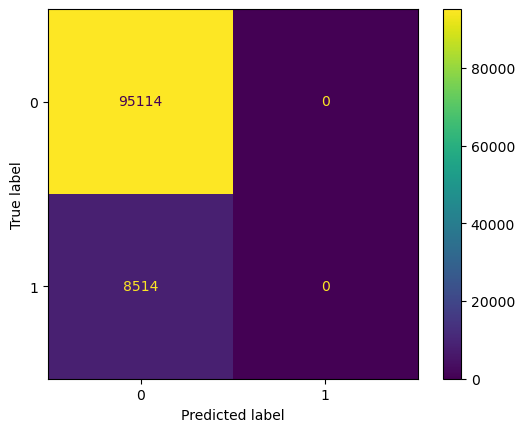

In [19]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')), #Imputing median for missing values
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#Estimator pipeline with our preprocessing in there
multi_nb_classifier = Pipeline([
    ('pre', preprocess),
    ('tSVD', TruncatedSVD(n_components=75)),
    ('mms', MinMaxScaler()),
    ('mnb', MultinomialNB(alpha = .0001))
])

#Fit model
multi_nb_classifier.fit(X_train_cleaned, y_train);

#Metrics
history.append(my_metrics(multi_nb_classifier, X_train_cleaned, X_test_cleaned))

pd.DataFrame(history, index = ['impute with median', 'gridsearch over params', 'impute with median and group missing into one category', 
                               'MinMax Scaler', 'TruncatedSVD'] )

This is just the base model, very bad.

# Sixth Model
**Strategy:**
- Use our thrid model with an oversampler to help with the imbalanced data

Train Accuracy: 0.3254021609415761
Test Recall: 0.829183305927492
Test Accuracy: 0.3255104797931061
Balanced Accuracy: 0.5555705024450242
Recall: 0.8308668076109936

Test Confusion Matrix:


,balanced_accuracy,recall,precision,f1_score
impute with median,0.557551,0.828635,0.094165,0.169112
gridsearch over params,0.562204,0.812309,0.095597,0.171063
impute with median and group missing into one category,0.556652,0.828635,0.093950,0.168766
MinMax Scaler,0.686953,0.483322,0.283363,0.357267
TruncatedSVD,0.500000,0.000000,0.000000,0.000000
RandomOverSampler,0.555571,0.830867,0.093658,0.168340


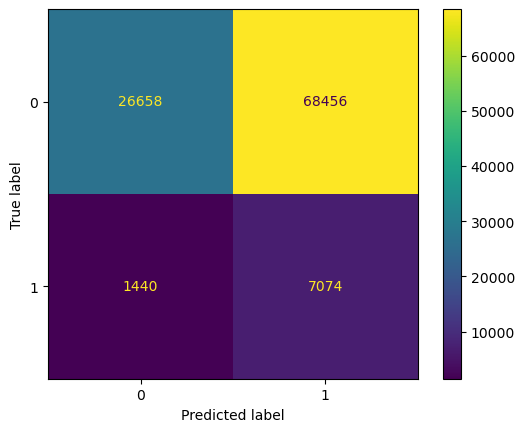

In [20]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')) #Imputing median for missing values
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#USing dufferent function for to make pipeline to accommodate for RandomOverSampler
multi_nb_classifier = make_pipeline(preprocess, RandomOverSampler(sampling_strategy = 1 ,random_state = 42), MultinomialNB(alpha = .00000001))

#Fit model
multi_nb_classifier.fit(X_train_cleaned, y_train);

#Metrics
history.append(my_metrics(multi_nb_classifier, X_train_cleaned, X_test_cleaned))

pd.DataFrame(history, index = ['impute with median', 'gridsearch over params', 'impute with median and group missing into one category', 
                               'MinMax Scaler', 'TruncatedSVD', 'RandomOverSampler'] )

## With MinMax Scaler

Train Accuracy: 0.7585876358630096
Test Recall: 0.7329496515543027
Test Accuracy: 0.7568514301154128
Balanced Accuracy: 0.7476635235768585
Recall: 0.7366690157387832

Test Confusion Matrix:


,balanced_accuracy,recall,precision,f1_score
impute with median,0.557551,0.828635,0.094165,0.169112
gridsearch over params,0.562204,0.812309,0.095597,0.171063
impute with median and group missing into one category,0.556652,0.828635,0.093950,0.168766
MinMax Scaler,0.686953,0.483322,0.283363,0.357267
TruncatedSVD,0.500000,0.000000,0.000000,0.000000
RandomOverSampler,0.555571,0.830867,0.093658,0.168340
ROS with MinMaxScaler,0.747664,0.736669,0.214596,0.332371


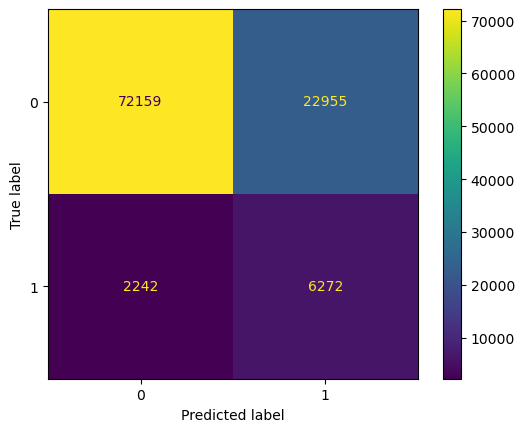

In [21]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')), #Imputing median for missing values
    ('mms', MinMaxScaler())
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#USing dufferent function for to make pipeline to accommodate for RandomOverSampler
multi_nb_classifier = make_pipeline(preprocess, RandomOverSampler(sampling_strategy = 1 ,random_state = 42), MultinomialNB(alpha = .00000001))

#Fit model
multi_nb_classifier.fit(X_train_cleaned, y_train);

#Metrics
history.append(my_metrics(multi_nb_classifier, X_train_cleaned, X_test_cleaned))

pd.DataFrame(history, index = ['impute with median', 'gridsearch over params', 'impute with median and group missing into one category', 
                               'MinMax Scaler', 'TruncatedSVD', 'RandomOverSampler', 'ROS with MinMaxScaler'])

Best model so far, Not as high of a recall, but much better balanced accuracy

## With MinMax and Polynomial Features

Train Accuracy: 0.7670152436768817
Test Recall: 0.7251585623678647
Test Accuracy: 0.7654108928088933
Balanced Accuracy: 0.7475675234005384
Recall: 0.726215644820296

Test Confusion Matrix:


,balanced_accuracy,recall,precision,f1_score
impute with median,0.557551,0.828635,0.094165,0.169112
gridsearch over params,0.562204,0.812309,0.095597,0.171063
impute with median and group missing into one category,0.556652,0.828635,0.093950,0.168766
MinMax Scaler,0.686953,0.483322,0.283363,0.357267
TruncatedSVD,0.500000,0.000000,0.000000,0.000000
RandomOverSampler,0.555571,0.830867,0.093658,0.168340
ROS with MinMaxScaler,0.747664,0.736669,0.214596,0.332371
ROS w/ Polynomial feature w/ MMS,0.747568,0.726216,0.219551,0.337169


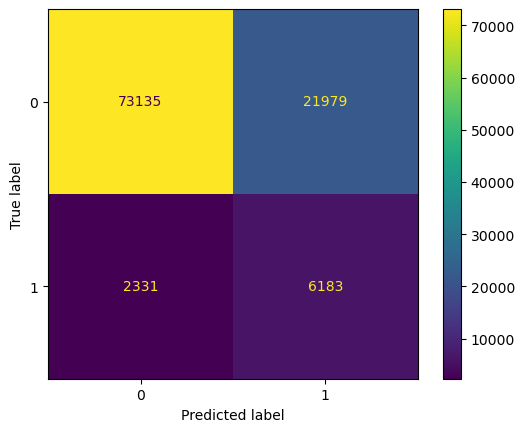

In [22]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')), #Imputing median for missing values
    ('mms', MinMaxScaler())
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#USing dufferent function for to make pipeline to accommodate for RandomOverSampler
multi_nb_classifier = make_pipeline(preprocess, PolynomialFeatures(), RandomOverSampler(sampling_strategy = 1 ,random_state = 42), MultinomialNB(alpha = .00000001))

#Fit model
multi_nb_classifier.fit(X_train_cleaned, y_train);

#Metrics
history.append(my_metrics(multi_nb_classifier, X_train_cleaned, X_test_cleaned))

pd.DataFrame(history, index = ['impute with median', 'gridsearch over params', 'impute with median and group missing into one category', 
                               'MinMax Scaler', 'TruncatedSVD', 'RandomOverSampler', 'ROS with MinMaxScaler', 'ROS w/ Polynomial feature w/ MMS'])

# Seventh model:
**Strategy:**
- Same as sixth but with different oversampler, now SMOTE

Train Accuracy: 0.32452401707394746
Test Recall: 0.8274998042439903
Test Accuracy: 0.32414984367159455
Balanced Accuracy: 0.5545084669214049
Recall: 0.8301620859760395

Test Confusion Matrix:


,balanced_accuracy,recall,precision,f1_score
impute with median,0.557551,0.828635,0.094165,0.169112
gridsearch over params,0.562204,0.812309,0.095597,0.171063
impute with median and group missing into one category,0.556652,0.828635,0.093950,0.168766
MinMax Scaler,0.686953,0.483322,0.283363,0.357267
TruncatedSVD,0.500000,0.000000,0.000000,0.000000
RandomOverSampler,0.555571,0.830867,0.093658,0.168340
ROS with MinMaxScaler,0.747664,0.736669,0.214596,0.332371
ROS w/ Polynomial feature w/ MMS,0.747568,0.726216,0.219551,0.337169
SMOTE,0.554508,0.830162,0.093419,0.167940


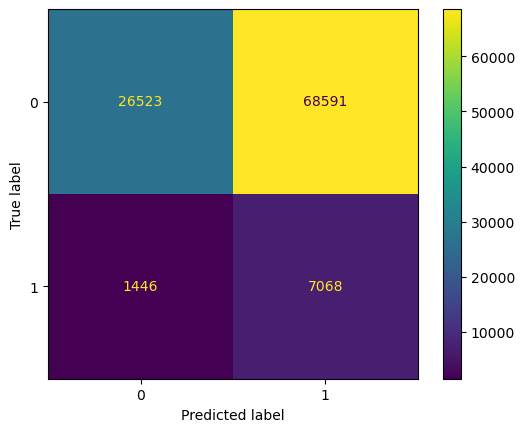

In [23]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')) #Imputing median for missing values
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#USing dufferent function for to make pipeline to accommodate for RandomOverSampler
multi_nb_classifier = make_pipeline(preprocess, SMOTE(random_state = 42), MultinomialNB(alpha = .00000001))

#Fit model
multi_nb_classifier.fit(X_train_cleaned, y_train);

#Metrics
history.append(my_metrics(multi_nb_classifier, X_train_cleaned, X_test_cleaned))

pd.DataFrame(history, index = ['impute with median', 'gridsearch over params', 'impute with median and group missing into one category', 
                               'MinMax Scaler', 'TruncatedSVD', 'RandomOverSampler', 'ROS with MinMaxScaler', 'ROS w/ Polynomial feature w/ MMS',
                              'SMOTE'])

## With MinMaxScaler

Train Accuracy: 0.750513858911552
Test Recall: 0.7501761804087386
Test Accuracy: 0.7484560157486394
Balanced Accuracy: 0.7511105573451566
Recall: 0.7542870566126381

Test Confusion Matrix:


,balanced_accuracy,recall,precision,f1_score
impute with median,0.557551,0.828635,0.094165,0.169112
gridsearch over params,0.562204,0.812309,0.095597,0.171063
impute with median and group missing into one category,0.556652,0.828635,0.093950,0.168766
MinMax Scaler,0.686953,0.483322,0.283363,0.357267
TruncatedSVD,0.500000,0.000000,0.000000,0.000000
RandomOverSampler,0.555571,0.830867,0.093658,0.168340
ROS with MinMaxScaler,0.747664,0.736669,0.214596,0.332371
ROS w/ Polynomial feature w/ MMS,0.747568,0.726216,0.219551,0.337169
SMOTE,0.554508,0.830162,0.093419,0.167940
SMOTE w/ MinMax,0.751111,0.754287,0.211271,0.330087


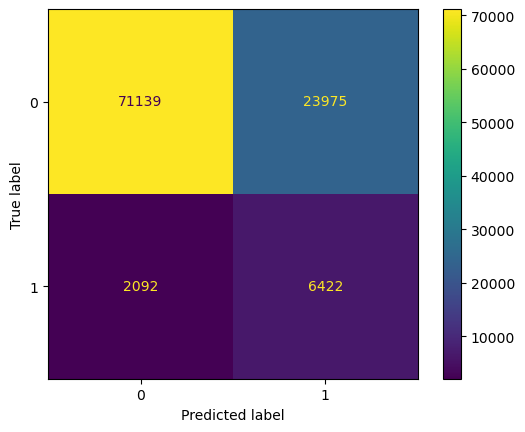

In [24]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')), #Imputing median for missing values
    ('mms', MinMaxScaler())
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#USing dufferent function for to make pipeline to accommodate for RandomOverSampler
multi_nb_classifier = make_pipeline(preprocess, SMOTE(random_state = 42), MultinomialNB(alpha = .00000001))

#Fit model
multi_nb_classifier.fit(X_train_cleaned, y_train);

#Metrics
history.append(my_metrics(multi_nb_classifier, X_train_cleaned, X_test_cleaned))

pd.DataFrame(history, index = ['impute with median', 'gridsearch over params', 'impute with median and group missing into one category', 
                               'MinMax Scaler', 'TruncatedSVD', 'RandomOverSampler', 'ROS with MinMaxScaler', 'ROS w/ Polynomial feature w/ MMS',
                              'SMOTE', 'SMOTE w/ MinMax'])

## SMOTE w/ MinMax w/ Polynomial Features

Train Accuracy: 0.7560850866724781
Test Recall: 0.7458303969931876
Test Accuracy: 0.7533099162388543
Balanced Accuracy: 0.7510812550698592
Recall: 0.7484143763213531

Test Confusion Matrix:


,balanced_accuracy,recall,precision,f1_score
impute with median,0.557551,0.828635,0.094165,0.169112
gridsearch over params,0.562204,0.812309,0.095597,0.171063
impute with median and group missing into one category,0.556652,0.828635,0.093950,0.168766
MinMax Scaler,0.686953,0.483322,0.283363,0.357267
TruncatedSVD,0.500000,0.000000,0.000000,0.000000
RandomOverSampler,0.555571,0.830867,0.093658,0.168340
ROS with MinMaxScaler,0.747664,0.736669,0.214596,0.332371
ROS w/ Polynomial feature w/ MMS,0.747568,0.726216,0.219551,0.337169
SMOTE,0.554508,0.830162,0.093419,0.167940
SMOTE w/ MinMax,0.751111,0.754287,0.211271,0.330087


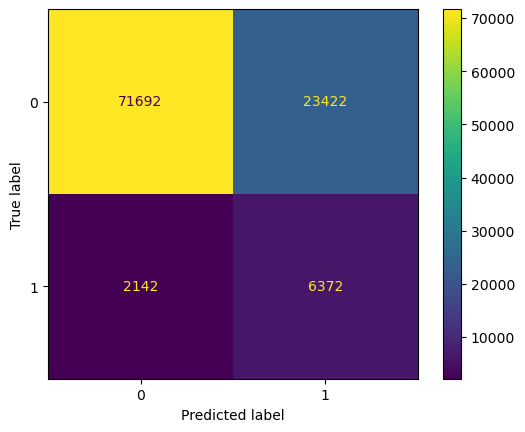

In [25]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')), #Imputing median for missing values
    ('mms', MinMaxScaler())
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#USing dufferent function for to make pipeline to accommodate for RandomOverSampler
multi_nb_classifier = make_pipeline(preprocess, PolynomialFeatures(), SMOTE(random_state = 42), MultinomialNB(alpha = .00000001))

#Fit model
multi_nb_classifier.fit(X_train_cleaned, y_train);

#Metrics
history.append(my_metrics(multi_nb_classifier, X_train_cleaned, X_test_cleaned))

pd.DataFrame(history, index = ['impute with median', 'gridsearch over params', 'impute with median and group missing into one category', 
                               'MinMax Scaler', 'TruncatedSVD', 'RandomOverSampler', 'ROS with MinMaxScaler', 'ROS w/ Polynomial feature w/ MMS',
                              'SMOTE', 'SMOTE w/ MinMax', 'SMOTE w/ Polynomial feature w/ MMS'])

# Eighth model:
**Strategy:**
- Same as sixth but with different oversampler, now with ADYSON

Train Accuracy: 0.3226294136379281
Test Recall: 0.8298097251585623
Test Accuracy: 0.32214266414482573
Balanced Accuracy: 0.5540032116745935
Recall: 0.8314540756401222

Test Confusion Matrix:


,balanced_accuracy,recall,precision,f1_score
impute with median,0.557551,0.828635,0.094165,0.169112
gridsearch over params,0.562204,0.812309,0.095597,0.171063
impute with median and group missing into one category,0.556652,0.828635,0.093950,0.168766
MinMax Scaler,0.686953,0.483322,0.283363,0.357267
TruncatedSVD,0.500000,0.000000,0.000000,0.000000
RandomOverSampler,0.555571,0.830867,0.093658,0.168340
ROS with MinMaxScaler,0.747664,0.736669,0.214596,0.332371
ROS w/ Polynomial feature w/ MMS,0.747568,0.726216,0.219551,0.337169
SMOTE,0.554508,0.830162,0.093419,0.167940
SMOTE w/ MinMax,0.751111,0.754287,0.211271,0.330087


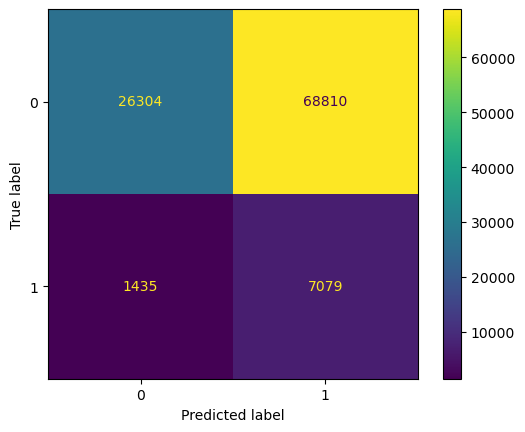

In [26]:
#Pipeline for numercal features that simple imputes with the median
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')) #Imputing median for missing values
])

#Pipeline for categorical features that one hot encodes them
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop = 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('numerical', num_pipe, numerical_features),
    ('categorical', cat_pipe, categorical_features)
])

#USing dufferent function for to make pipeline to accommodate for RandomOverSampler
multi_nb_classifier = make_pipeline(preprocess, ADASYN(random_state = 42), MultinomialNB(alpha = .00000001))

#Fit model
multi_nb_classifier.fit(X_train_cleaned, y_train);

#Metrics
history.append(my_metrics(multi_nb_classifier, X_train_cleaned, X_test_cleaned))

pd.DataFrame(history, index = ['impute with median', 'gridsearch over params', 'impute with median and group missing into one category', 
                               'MinMax Scaler', 'TruncatedSVD', 'RandomOverSampler', 'ROS with MinMaxScaler', 'ROS w/ Polynomial feature w/ MMS',
                              'SMOTE', 'SMOTE w/ MinMax', 'SMOTE w/ Polynomial feature w/ MMS', 'ADYSON'])

ADASYN had slightly better recall, bu barely and not worth the time it took to train.

# Save Metric scores to csv

In [27]:
history_df = pd.DataFrame(history, index = ['impute with median', 'gridsearch over params', 'impute with median and group missing into one category', 
                               'MinMax Scaler', 'TruncatedSVD', 'RandomOverSampler', 'ROS with MinMaxScaler', 'ROS w/ Polynomial feature w/ MMS',
                              'SMOTE', 'SMOTE w/ MinMax', 'SMOTE w/ Polynomial feature w/ MMS', 'ADYSON'])

history_df.to_csv('../data/scores_MulinomialNaiveBayes.csv')